In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.expand_frame_repr',False)
pd.set_option('max.colwidth',-1)



In [2]:
from google.colab import files
uploaded = files.upload()

Saving deliveries.csv to deliveries.csv
Saving matches.csv to matches.csv


In [3]:
matches = pd.read_csv('matches.csv')
deliveries = pd.read_csv('deliveries.csv')


In [4]:
df = deliveries.copy()
mf = matches.copy()

In [5]:
df['one'] = df['batsman_runs'].apply(lambda x:  1 if x==1 else 0 )
df['two'] = df['batsman_runs'].apply(lambda x: 1 if x==2 else 0 )
df['three'] = df['batsman_runs'].apply(lambda x: 1 if x==3 else 0 )
df['four'] = df['batsman_runs'].apply(lambda x:  1 if x==4 else 0 )
df['six'] = df['batsman_runs'].apply(lambda x: 1 if x==6 else 0 )
df['dot'] = df['batsman_runs'].apply(lambda x: 1 if x==0 else 0 )


In [6]:
def phase(over):
  if over < 6:
    return 'Powerplay'
  elif over < 15:
    return 'Middle'
  else:
    return 'Death'


In [7]:
df['Phase'] = df['over'].apply(lambda x : phase(x))

Extracting Player Details for Given Phase:

In [10]:
def Custom(df,current_phase):
  df = df[df.Phase == current_phase]
  df.reset_index(inplace = True,drop = True)

  runs = pd.DataFrame(df.groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'Runs'}))
  balls = pd.DataFrame(df.groupby(['batsman'])['batsman_runs'].count().reset_index().rename(columns={'batsman_runs':'Balls_Faced'}))
  dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count().reset_index().rename(columns={'player_dismissed':'Dismissals'}))
  innings = pd.DataFrame(df.groupby(['batsman'])['matchId'].apply(lambda x : len(list(np.unique(x)))).reset_index().rename(columns={'matchId':'Innings'}))

  ones = pd.DataFrame(df.groupby(['batsman'])['one'].sum().reset_index().rename(columns={'one':'Ones'}))
  twos = pd.DataFrame(df.groupby(['batsman'])['two'].sum().reset_index().rename(columns={'two':'Twos'}))
  three = pd.DataFrame(df.groupby(['batsman'])['three'].sum().reset_index().rename(columns={'three':'Threes'}))
  fours = pd.DataFrame(df.groupby(['batsman'])['four'].sum().reset_index().rename(columns={'four':'Fours'}))
  sixes = pd.DataFrame(df.groupby(['batsman'])['six'].sum().reset_index().rename(columns={'six':'Sixes'}))
  dots = pd.DataFrame(df.groupby(['batsman'])['dot'].sum().reset_index().rename(columns={'dot':'Dots'}))

  df = pd.merge(runs,balls,on='batsman').merge(dismissals,on='batsman').merge(innings,on='batsman').merge(ones,on='batsman').merge(twos,on='batsman').merge(three,on='batsman').merge(fours,on='batsman').merge(sixes,on='batsman').merge(dots,on='batsman')
  
  
  return df

In [11]:
df1 = Custom(df,'Powerplay')
df2 = Custom(df,'Middle')
df3 = Custom(df,'Death')


In [12]:
df1 = df1[df1.Balls_Faced > 25]

In [13]:
df1['RPI'] = df1.apply(lambda x : x['Runs']/x['Innings'],axis=1)

In [14]:
df1['Boundaries'] = df1['Fours'] + df1['Sixes'] 

In [15]:
def BPB(Balls,Boundary):
  if Boundary > 0 :
    return Balls / Boundary 
  else:
    return Balls

def BPD(Balls,Dismissals):
  if Dismissals > 0:
    return Balls / Dismissals
  else:
    return Balls

def Average(Runs,Dismissals):
  if Dismissals > 0:
    return Runs/Dismissals
  else:
    return Runs

In [16]:
df1['BPB'] = df1.apply(lambda x : BPB(x['Balls_Faced'],x['Boundaries']),axis=1)
df1['BPD'] = df1.apply(lambda x : BPB(x['Balls_Faced'],x['Dismissals']),axis=1)
df1['Average'] = df1.apply(lambda x : BPB(x['Runs'],x['Dismissals']),axis=1)
df1['StrikeRate'] = df1.apply(lambda x : (x['Runs'] / x['Balls_Faced'])*100,axis=1)
df1['DotPercentage'] = df1.apply(lambda x: (x['Dots']/x['Balls_Faced'])*100,axis=1)

***Pair Wise Comparison to determine criteria weights:***

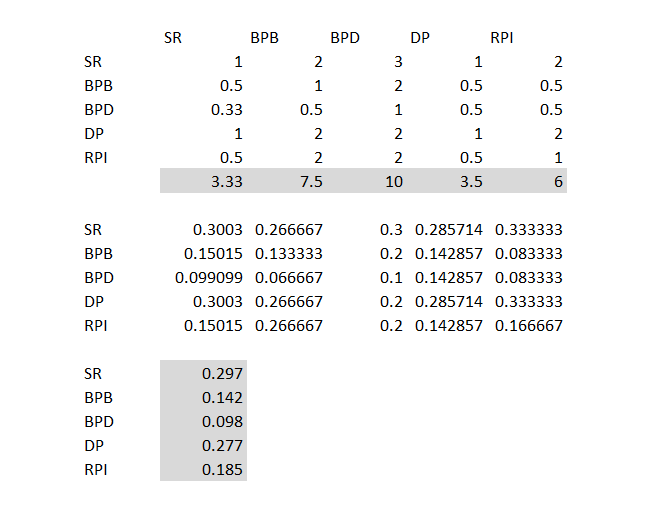

In [55]:
wt_SR,wt_BPB,wt_BPD,wt_DP,wt_RPI = 0.297,0.142,0.098,0.277,0.185

**Calculating the score using MinMax Value:**

In [56]:
min_val = min(df1['StrikeRate']) 
max_val = max(df1['StrikeRate'])

df1['mx_SR'] = df1['StrikeRate'].apply(lambda x: (x - min_val)/(max_val - min_val))

In [57]:
min_val = max(df1['BPB']) 
max_val = min(df1['BPB'])

df1['mx_BPB'] = df1['BPB'].apply(lambda x: (x - min_val)/(max_val - min_val))

In [59]:
min_val = min(df1['BPD'])
max_val = max(df1['BPD'])

df1['mx_BPD'] = df1['BPD'].apply(lambda x : (x - min_val)/(max_val - min_val))

In [60]:
min_val = max(df1['DotPercentage'])
max_val = min(df1['DotPercentage'])

df1['mx_DP'] = df1['DotPercentage'].apply(lambda x : (x - min_val)/(max_val - min_val))

In [61]:
min_val = min(df1['RPI'])
max_val = max(df1['RPI'])

df1['mx_RPI'] = df1['RPI'].apply(lambda x : (x - min_val)/(max_val - min_val))

In [62]:
df1.head(1)

,batsman,Runs,Balls_Faced,Dismissals,Innings,Ones,Twos,Threes,Fours,Sixes,Dots,RPI,Boundaries,BPB,BPD,Average,StrikeRate,DotPercentage,mx_SR,mx_BPB,mx_BPD,mx_DotPercentage,mx_RPI,mx_DP,minmax_score
2,A Chopra,27,41,2,5,11,0,0,4,0,26,5.4,4,10.25,20.5,13.5,65.853659,63.414634,0.223253,0.726744,0.173038,0.62906,0.179092,0.37094,0.444103


In [63]:
df1['minmax_score'] = df1.apply(lambda x : (x['mx_SR']*0.297 + x['mx_BPB']*0.142 + x['mx_BPD']*0.098 + x['mx_DP']*0.277 + x['mx_RPI']*0.185),axis=1)

In [65]:
df1[['batsman','Runs','Balls_Faced','Innings','StrikeRate','DotPercentage','BPB','BPD','minmax_score']].sort_values(by='minmax_score',ascending=False).head(5).reset_index()

,index,batsman,Runs,Balls_Faced,Innings,StrikeRate,DotPercentage,BPB,BPD,minmax_score
0,303,UT Khawaja,107,79,6,135.443038,40.506329,4.937500,26.333333,0.810595
1,18,AD Hales,114,82,6,139.024390,43.902439,4.823529,27.333333,0.806414
2,214,PP Shaw,1129,787,63,143.456163,43.837357,4.142105,20.179487,0.800210
3,121,JM Bairstow,695,487,36,142.710472,47.433265,4.127119,30.437500,0.798068
4,115,JC Buttler,1230,882,62,139.455782,49.206349,4.160377,33.923077,0.787250


**Calculating the score using Standardisation method:**

In [82]:
mean_val = np.mean(df1['StrikeRate'])
std_val = np.std(df1['StrikeRate'])

df1['st_SR'] = df1['StrikeRate'].apply(lambda x : (x - mean_val)/(std_val))

In [84]:
mean_val = np.mean(df1['BPB'])
std_val = np.std(df1['BPB'])

df1['st_BPB'] = df1['BPB'].apply(lambda x : (x - mean_val)/(std_val))

In [85]:
mean_val = np.mean(df1['BPD'])
std_val = np.std(df1['BPD'])

df1['st_BPD'] = df1['BPD'].apply(lambda x : (x - mean_val)/(std_val))

In [86]:
mean_val = np.mean(df1['DotPercentage'])
std_val = np.std(df1['DotPercentage'])

df1['st_DP'] = df1['DotPercentage'].apply(lambda x : (x - mean_val)/(std_val))

In [87]:
mean_val = np.mean(df1['RPI'])
std_val = np.std(df1['RPI'])

df1['st_RPI'] = df1['RPI'].apply(lambda x : (x - mean_val)/(std_val))

In [88]:
df1['st_score'] = df1.apply(lambda x : (x['st_SR']*0.297 + x['st_BPB']*0.142 + x['st_BPD']*0.098 + x['st_DP']*0.277 + x['st_RPI']*0.185), axis=1)

In [91]:
df1.sort_values(by='st_score',ascending=False).head(1).reset_index()

,index,batsman,Runs,Balls_Faced,Dismissals,Innings,Ones,Twos,Threes,Fours,Sixes,Dots,RPI,Boundaries,BPB,BPD,Average,StrikeRate,DotPercentage,mx_SR,mx_BPB,mx_BPD,mx_DotPercentage,mx_RPI,mx_DP,minmax_score,st_SR,st_BPB,st_BPD,st_DP,st_RPI,st_score
0,115,JC Buttler,1230,882,26,62,204,30,1,157,55,434,19.83871,212,4.160377,33.923077,47.307692,139.455782,49.206349,0.747047,0.962776,0.335087,0.238902,1.0,0.761098,0.78725,1.42379,-0.755451,0.621748,-0.745542,2.052767,0.54977


**Calculating the score using the Topsis Method:**

In [93]:
df1['calc_SR'] = df1['StrikeRate'].apply(lambda x: x*x)
df1['calc_BPB'] = df1['BPB'].apply(lambda x: x*x)
df1['calc_BPD'] = df1['BPD'].apply(lambda x: x*x)
df1['calc_DP'] = df1['DotPercentage'].apply(lambda x: x*x)
df1['calc_RPI'] = df1['RPI'].apply(lambda x: x*x)



In [100]:
sq_SR,sq_BPB,sq_BPD,sq_DP,sq_RPI = np.sqrt(df1[['calc_SR','calc_BPB','calc_BPD','calc_DP','calc_RPI']].sum(axis=0))

In [105]:
df1['calc_SR'] = df1['StrikeRate'].apply(lambda x: x/sq_SR)
df1['calc_BPB'] = df1['BPB'].apply(lambda x: x/sq_BPB)
df1['calc_BPD'] = df1['BPD'].apply(lambda x: x/sq_BPD)
df1['calc_DP'] = df1['DotPercentage'].apply(lambda x: x/sq_DP)
df1['calc_RPI'] = df1['RPI'].apply(lambda x: x/sq_RPI)



In [106]:
df1['calc_SR'] = df1['StrikeRate'].apply(lambda x: x*wt_SR)
df1['calc_BPB'] = df1['BPB'].apply(lambda x: x*wt_BPB)
df1['calc_BPD'] = df1['BPD'].apply(lambda x: x*wt_BPD)
df1['calc_DP'] = df1['DotPercentage'].apply(lambda x: x*wt_DP)
df1['calc_RPI'] = df1['RPI'].apply(lambda x: x*wt_RPI)

best_SR, Worst_SR = max(df1['calc_SR']) , min(df1['calc_SR'])
best_BPB, Worst_BPB = min(df1['calc_BPB']) , max(df1['calc_BPB'])
best_BPD, Worst_BPD = max(df1['calc_BPD']) , min(df1['calc_BPD'])
best_DP, Worst_DP = min(df1['calc_DP']) , max(df1['calc_DP'])
best_RPI, Worst_RPI = max(df1['calc_RPI']) , min(df1['calc_RPI'])



**Comparing against the best and worst values:**

In [110]:
df1['d_best_SR'] = df1['calc_SR'].apply(lambda x : (x-best_SR)*(x-best_SR))
df1['d_best_BPB'] = df1['calc_BPB'].apply(lambda x : (x-best_BPB)*(x-best_BPB))
df1['d_best_BPD'] = df1['calc_BPD'].apply(lambda x : (x-best_BPD)*(x-best_BPD))
df1['d_best_DP'] = df1['calc_DP'].apply(lambda x : (x-best_DP)*(x-best_DP))
df1['d_best_RPI'] = df1['calc_RPI'].apply(lambda x : (x-best_RPI)*(x-best_RPI))

df1['d_best_score'] = df1.apply(lambda x : (x['d_best_SR'] + x['d_best_BPB'] + x['d_best_BPD'] + x['d_best_DP'] + x['d_best_RPI']),axis=1)




In [112]:
df1['d_worst_SR'] = df1['calc_SR'].apply(lambda x : (x-Worst_SR)*(x-Worst_SR))
df1['d_worst_BPB'] = df1['calc_BPB'].apply(lambda x : (x-Worst_BPB)*(x-Worst_BPB))
df1['d_worst_BPD'] = df1['calc_BPD'].apply(lambda x : (x-Worst_BPD)*(x-Worst_BPD))
df1['d_worst_DP'] = df1['calc_DP'].apply(lambda x : (x-Worst_DP)*(x-Worst_DP))
df1['d_worst_RPI'] = df1['calc_RPI'].apply(lambda x : (x-Worst_RPI)*(x-Worst_RPI))

df1['d_worst_score'] = df1.apply(lambda x : (x['d_worst_SR'] + x['d_worst_BPB'] + x['d_worst_BPD'] + x['d_worst_DP'] + x['d_worst_RPI']),axis=1)




In [115]:
df1['score'] = df1.apply(lambda x: x['d_worst_score']/(x['d_worst_score'] + x['d_best_score']),axis=1)

In [130]:
df1[['batsman','StrikeRate','RPI','BPB','BPD','DotPercentage','score']].sort_values(by='score',ascending=False).head(15)

,batsman,StrikeRate,RPI,BPB,BPD,DotPercentage,score
208,PBB Rajapaksa,175.000000,9.333333,3.200000,10.666667,46.875000,0.965213
154,LS Livingstone,165.432099,12.181818,3.681818,20.250000,46.913580,0.964649
271,SP Narine,166.250000,15.833333,3.225806,11.764706,50.000000,0.957402
135,KH Pandya,159.259259,4.777778,3.375000,13.500000,44.444444,0.944939
121,JM Bairstow,142.710472,19.305556,4.127119,30.437500,47.433265,0.897653
266,SN Khan,144.230769,10.714286,4.333333,17.333333,42.307692,0.895915
214,PP Shaw,143.456163,17.920635,4.142105,20.179487,43.837357,0.895807
171,MJ Lumb,143.312102,18.750000,3.738095,26.166667,49.044586,0.895345
55,C Munro,142.391304,16.375000,4.181818,23.000000,45.652174,0.890596
58,CA Lynn,140.867993,19.475000,4.066176,32.529412,49.005425,0.886704


## ***Conclusion:***

I tried to check the score using different normalisation methods and We will go with the result based on Topsis method as I feel this gives the result that is more relevant

According to the method, it is concluded that Sunrisers should go for below players since all other players were already representing other teams.

1) Colin Munro
2) Chris Lynn
3) Evin Lewis

These are the top 3 players who will be best suitable for the role of Pinch Hitter.